# Analyzing and delving into portfolio optimization

## Import the data and describe the sample

In [53]:
# Import libraries

import pandas as pd
import numpy as np
import random
import re
import requests
from bs4 import BeautifulSoup

from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import plotly.express as px
import plotly.graph_objects as go

import quantstats as qs
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint

from tqdm import tqdm

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

import warnings
warnings.filterwarnings('ignore')

from pypfopt import black_litterman, BlackLittermanModel, EfficientFrontier, risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import mean_historical_return
import statsmodels.api as sm
from collections import defaultdict
import ipywidgets as widgets
from IPython.display import display
import yfinance as yf
import time
import plotly.io as pio

from datetime import datetime, timedelta
from typing import List, Optional, Tuple, Union

import cvxpy as cp
import plotly.figure_factory as ff
import pypfopt as ppo
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.covariance import ledoit_wolf

### Check if data contains any null values.

In [158]:
start_date = '2010-07-01'
end_date = '2015-01-01'
tickers = ['AAPL', 'BA', 'T', 'MGM', 'AMZN', 'IBM', 'TSLA', 'GOOG']

# Download daily data
df_data = yf.download(tickers=tickers, start=start_date, end=end_date, interval='1d')
# Select only columns that contain "Close" in their names


# Adj Close
close_columns = [col for col in df_data.columns if 'Close' in col]
df_data = df_data[close_columns]

# Convert the index to datetime and format it to show only the year, month, and day
df_data.index = pd.to_datetime(df_data.index).date

# Ensure the index is named appropriately
df_data.index.name = 'Date'

df_data = df_data.reset_index()

#df_data = pd.read_csv('Stocks&s&p500_data.csv')
# Now, sort the DataFrame by 'Date'
df_data_sorted = df_data.sort_values(by='Date')
# Flatten the columns
df_data.columns = df_data.columns.get_level_values(1)

# Rename the first column to 'Date' (since it had no stock name before)
df_data.rename(columns={df_data.columns[0]: 'Date'}, inplace=True)
# Optionally, reset the index after sorting (if you want a clean index)
#df_data = df_data_sorted.reset_index(drop=True)

# Convert 'Date' column to a proper datetime format (if not already)
df_data['Date'] = pd.to_datetime(df_data['Date'])


# Set the 'Date' column as the index
df_data_index = df_data.copy()
df_data_index.set_index('Date', inplace=True)

df_data

[*********************100%***********************]  8 of 8 completed


Ticker,Date,AAPL,AMZN,BA,GOOG,IBM,MGM,T,TSLA
0,2010-07-01,8.874286,5.5480,62.259998,10.946221,117.179733,9.700000,18.383686,1.464000
1,2010-07-02,8.819286,5.4570,61.939999,10.872995,116.500954,9.480000,18.345921,1.280000
2,2010-07-06,8.879643,5.5030,61.360001,10.861040,118.030594,9.270000,18.436556,1.074000
3,2010-07-07,9.238214,5.6715,63.299999,11.212971,121.414917,9.900000,18.376133,1.053333
4,2010-07-08,9.217500,5.8110,64.730003,11.371377,122.342255,9.820000,18.557402,1.164000
...,...,...,...,...,...,...,...,...,...
1129,2014-12-24,28.002501,15.1515,131.240005,26.366112,154.703629,20.770000,25.649548,14.817333
1130,2014-12-26,28.497499,15.4545,131.630005,26.628391,155.200760,21.110001,25.808157,15.188000
1131,2014-12-29,28.477501,15.6020,132.289993,26.443897,153.451248,21.480000,25.762840,15.047333
1132,2014-12-30,28.129999,15.5150,131.830002,26.448385,153.011475,21.450001,25.740181,14.815333


In [159]:
# Check for null values in each column
df_data.isnull().sum()

Ticker
Date    0
AAPL    0
AMZN    0
BA      0
GOOG    0
IBM     0
MGM     0
T       0
TSLA    0
dtype: int64

## Plot the data

In [160]:
def plot_df(df):
    # Specify the columns to plot
    columns_to_plot = df.drop(['Date'], axis=1).columns.tolist()

    # Create a figure and axis for the plot
    plt.figure(figsize=(10, 6))
    sns.set_style("darkgrid")
    
    # Plot each column against 'Date'
    for col in columns_to_plot:
        plt.plot(df['Date'], df[col], label=col)

    # Add labels and title
    plt.xlabel('Date')
    plt.xticks(np.arange(0, len(df), step=90), rotation=45)   # Set the xticks to be every 90 days
    plt.ylabel('Price $')
    plt.title('Stock Prices Over Time')
    plt.legend(loc='best')

    # Rotate the date labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.tight_layout()
    plt.show()
    

In [161]:
def plot_df(df):
    # Ensure the 'Date' column is in datetime format
    if not np.issubdtype(df['Date'].dtype, np.datetime64):
        df['Date'] = pd.to_datetime(df['Date'])

    # Specify the columns to plot (excluding 'Date')
    columns_to_plot = df.drop(['Date'], axis=1).columns.tolist()

    # Create a figure and axis for the plot
    plt.figure(figsize=(12, 6))
    sns.set_style("darkgrid")
    
    # Plot each column against 'Date'
    for col in columns_to_plot:
        plt.plot(df['Date'], df[col], label=col)

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.title('Stock Prices Over Time')
    plt.legend(loc='best')

    # Format x-axis ticks for readability
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))  # Set date format
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=3))  # Set major ticks every 3 months
    plt.xticks(rotation=45)

    # Display the plot
    plt.tight_layout()
    plt.show()

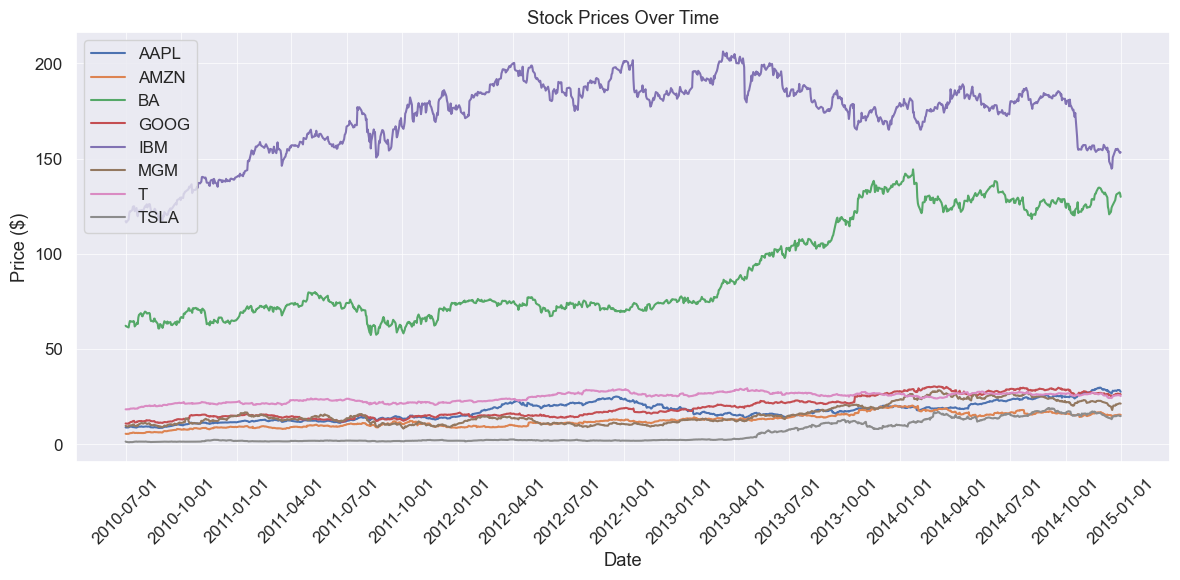

In [162]:
plot_df(df_data)

## Print out normalized (scaled) stock prices

In [163]:
def normalizer(df):
    return df/df.iloc[0]
    
df_norm = normalizer(df_data.drop(columns=['Date'], axis = 1))
df_norm['Date'] = df_data['Date']
#to put date at the beginning:
df_norm = df_norm[['Date', 'AAPL', 'BA', 'T', 'MGM', 'AMZN', 'IBM', 'TSLA', 'GOOG']]
df_norm

Ticker,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG
0,2010-07-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2010-07-02,0.993802,0.994860,0.997946,0.977320,0.983598,0.994207,0.874317,0.993310
2,2010-07-06,1.000604,0.985545,1.002876,0.955670,0.991889,1.007261,0.733607,0.992218
3,2010-07-07,1.041009,1.016704,0.999589,1.020619,1.022260,1.036143,0.719490,1.024369
4,2010-07-08,1.038675,1.039672,1.009449,1.012371,1.047404,1.044056,0.795082,1.038840
...,...,...,...,...,...,...,...,...,...
1129,2014-12-24,3.155465,2.107935,1.395234,2.141237,2.730984,1.320225,10.121129,2.408695
1130,2014-12-26,3.211244,2.114199,1.403862,2.176289,2.785599,1.324468,10.374317,2.432656
1131,2014-12-29,3.208991,2.124799,1.401397,2.214433,2.812185,1.309537,10.278233,2.415801
1132,2014-12-30,3.169832,2.117411,1.400164,2.211340,2.796503,1.305784,10.119763,2.416211


### Plot normalized data

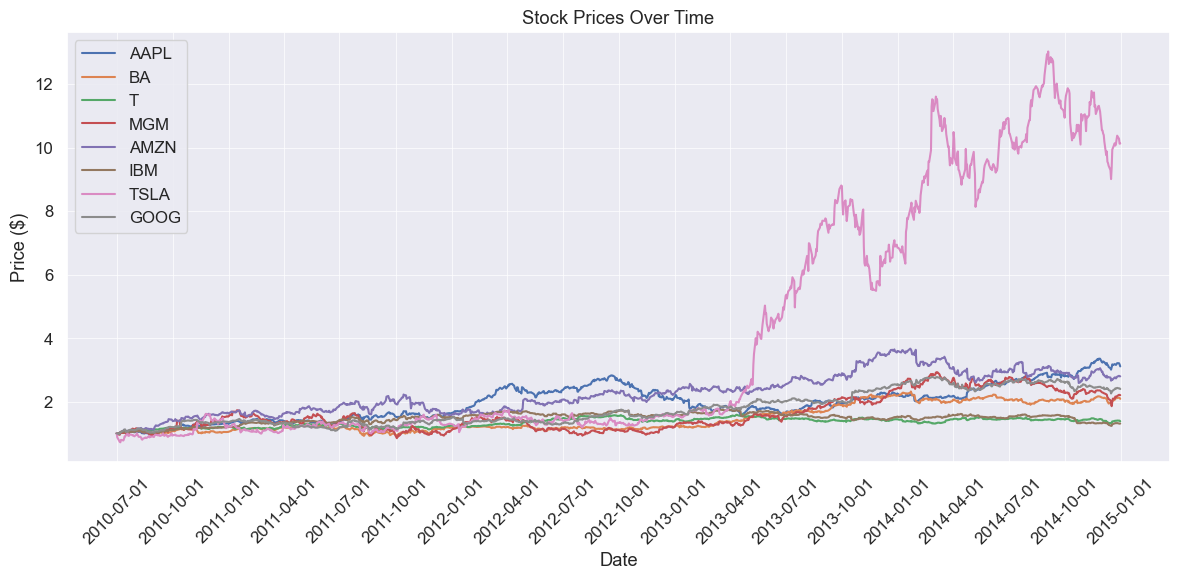

In [164]:
plot_df(df_norm)

## Calculate stock returns (1)

### Define a function to calculate stocks daily returns (for all stocks)

In [165]:
# Let's define a function to calculate stocks daily returns (for all stocks) 
def daily_return(df):
  df_daily_return = df.copy()

  # Loop through each stock (while ignoring time columns with index 0)
  for i in df.columns[1:]:
    
    # Loop through each row belonging to the stock
    for j in range(1, len(df)):

      # Calculate the percentage of change from the previous day
      df_daily_return[i][j] = ((df[i][j]- df[i][j-1])/df[i][j-1]) * 100
    
    # set the value of first row to zero since the previous value is not available
    df_daily_return[i][0] = 0
  
  return df_daily_return

stock_daily_return_df = daily_return(df_data)
stock_daily_return_df

Ticker,Date,AAPL,AMZN,BA,GOOG,IBM,MGM,T,TSLA
0,2010-07-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-07-02,-0.619761,-1.640232,-0.513973,-0.668961,-0.579264,-2.268044,-0.205429,-12.568307
2,2010-07-06,0.684376,0.842954,-0.936387,-0.109954,1.312985,-2.215180,0.494035,-16.093748
3,2010-07-07,4.038114,3.061974,3.161667,3.240303,2.867327,6.796107,-0.327734,-1.924298
4,2010-07-08,-0.224219,2.459661,2.259090,1.412706,0.763776,-0.808080,0.986435,10.506363
...,...,...,...,...,...,...,...,...,...
1129,2014-12-24,-0.470943,-1.064351,0.930560,-0.343017,-0.258879,-0.811844,-0.205700,0.583793
1130,2014-12-26,1.767695,1.999805,0.297165,0.994760,0.321344,1.636977,0.618371,2.501574
1131,2014-12-29,-0.070177,0.954415,0.501397,-0.692847,-1.127257,1.752719,-0.175591,-0.926172
1132,2014-12-30,-1.220268,-0.557620,-0.347714,0.016972,-0.286588,-0.139659,-0.087953,-1.541797


### Plot

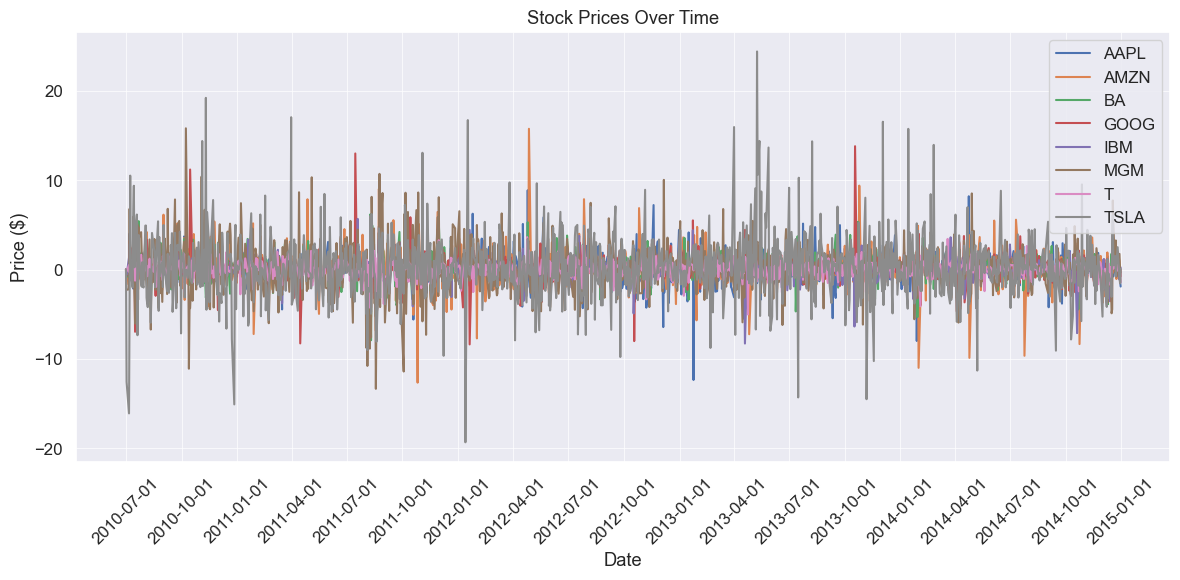

In [166]:
plot_df(stock_daily_return_df)

## Calculate stock returns (2)

### Calculate the correlations between daily returns

In [167]:
corr_matrix = stock_daily_return_df.corr()
corr_matrix

Ticker,AAPL,AMZN,BA,GOOG,IBM,MGM,T,TSLA
Ticker,,,,,,,,
AAPL,1.000000,0.292909,0.326150,0.387913,0.331362,0.356456,0.256134,0.201547
AMZN,0.292909,1.000000,0.362261,0.475877,0.358127,0.379821,0.276320,0.267281
BA,0.326150,0.362261,1.000000,0.422918,0.473341,0.455796,0.404111,0.232069
GOOG,0.387913,0.475877,0.422918,1.000000,0.392111,0.410855,0.327882,0.240339
IBM,0.331362,0.358127,0.473341,0.392111,1.000000,0.410151,0.431235,0.207605
MGM,0.356456,0.379821,0.455796,0.410855,0.410151,1.000000,0.316328,0.292955
T,0.256134,0.276320,0.404111,0.327882,0.431235,0.316328,1.000000,0.150048
TSLA,0.201547,0.267281,0.232069,0.240339,0.207605,0.292955,0.150048,1.000000


### Plot the correlation table as in heat-map

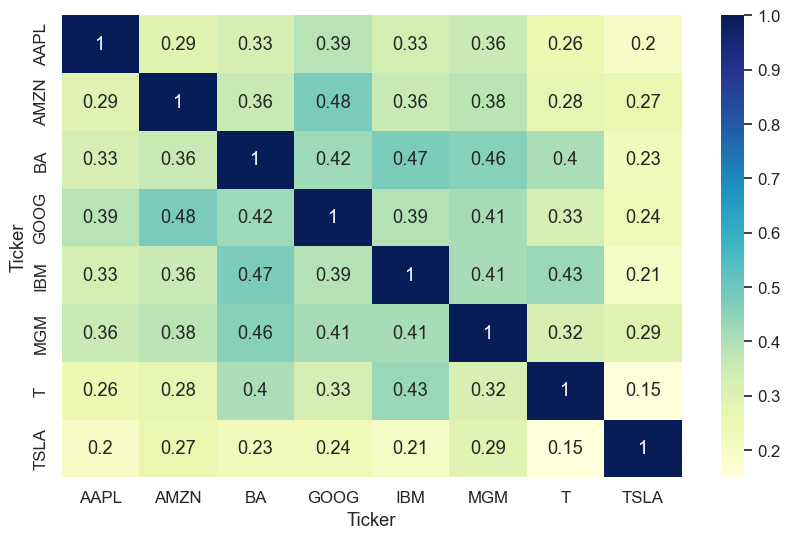

In [168]:
dataplot = sns.heatmap(stock_daily_return_df.corr(numeric_only=True), cmap="YlGnBu", annot=True)

## Calculate stock returns (3)

### Plot the histograms of daily returns

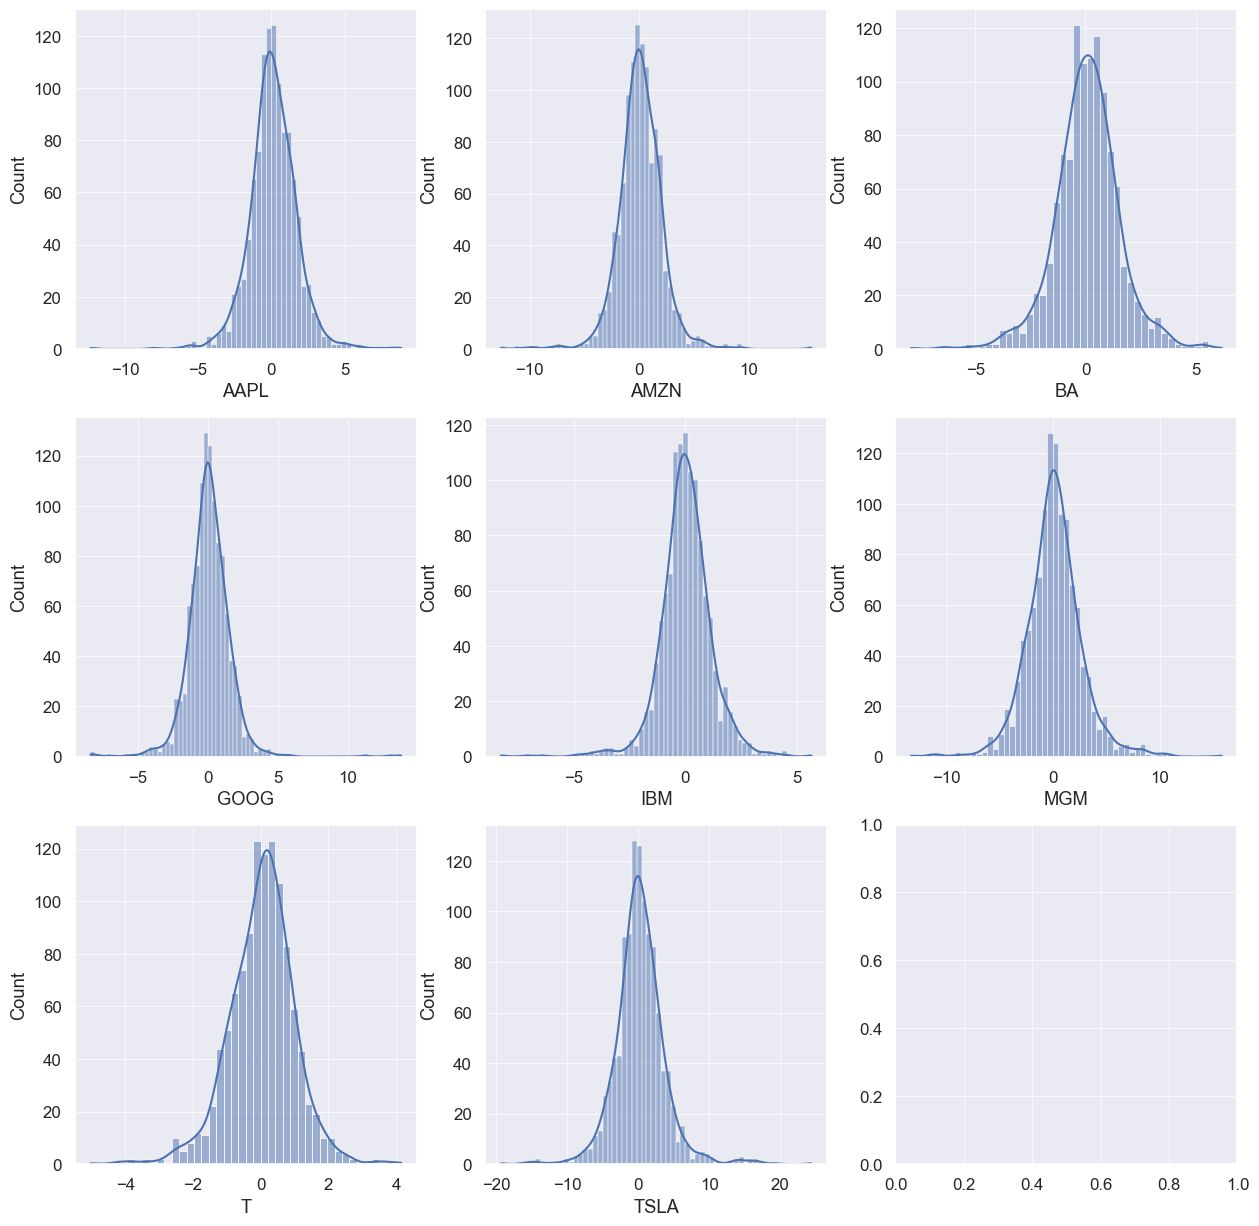

In [169]:
#plt.figure(figsize=(15, 5))
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i in stock_daily_return_df.drop('Date', axis=1).columns:
    sns.histplot(stock_daily_return_df[i], 
                 label = i, # Set the label as the name of the stock
                 kde = True, # Plot the kernel density estimation
                 ax = ax.flatten()[stock_daily_return_df.drop('Date', axis=1).columns.get_loc(i)], # Flatten the axes and select cyclically the right one
               
                #color = palette[stock_daily_return_df.drop('Date', axis=1).columns.get_loc(i)]    # Set the color of the plot
               )
plt.show()

##  Mean-Variance Optimization

In [170]:
def compute_returns(df, method='log'):

    returns_df = np.log(df.drop(['Date'], axis=1)/df.drop(['Date'], axis=1).shift(1))

    return returns_df

In [171]:
returns_dff = compute_returns(df_data)
returns_dff

Ticker,AAPL,AMZN,BA,GOOG,IBM,MGM,T,TSLA
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.006217,-0.016538,-0.005153,-0.006712,-0.005809,-0.022942,-0.002056,-0.134312
2,0.006820,0.008394,-0.009408,-0.001100,0.013044,-0.022401,0.004928,-0.175470
3,0.039587,0.030160,0.031127,0.031889,0.028270,0.065751,-0.003283,-0.019431
4,-0.002245,0.024299,0.022340,0.014028,0.007609,-0.008114,0.009816,0.099903
...,...,...,...,...,...,...,...,...
1129,-0.004721,-0.010701,0.009263,-0.003436,-0.002592,-0.008152,-0.002059,0.005821
1130,0.017523,0.019801,0.002967,0.009898,0.003208,0.016237,0.006165,0.024708
1131,-0.000702,0.009499,0.005001,-0.006953,-0.011337,0.017375,-0.001757,-0.009305
1132,-0.012278,-0.005592,-0.003483,0.000170,-0.002870,-0.001398,-0.000880,-0.015538


In [172]:
def portfolio_simulation(df, rf=0, n=20000):
    """
    Simulates portfolios with random weights and calculates return, variance, and Sharpe ratio for each.
    
    Parameters:
    returns (pd.DataFrame): DataFrame of daily returns for each asset.
    num_portfolios (int): Number of portfolios to simulate.
    risk_free_rate (float): Annualized risk-free rate for Sharpe ratio calculation.
    
    Returns:
    max_sharpe (float): Maximum Sharpe ratio achieved.
    max_sharpe_weights (np.ndarray): Weights of the portfolio with the maximum Sharpe ratio.
    """
    
    # Compute the returns
    returns = compute_returns(df) - rf/252   # The risk-free rate is annualized, so we divide it by 252
    avg_returns = returns.mean() * 252
    cov_matrix = returns.cov() * 252
    
    # Simulation
    portfolio_returns = []
    portfolio_std_devs = []
    sharpe_ratio = []
    weights_list = []
    np.random.seed(42)  # Set the seed to 42 for reproducibility

    for i in tqdm(range(n)):

        # Generating random weights using a Dirichlet distribution
        weights = np.random.dirichlet(np.ones(len(df.drop(['Date'], axis=1).columns)), size=1)[0]

        # # Generating random weights
        # weights = np.random.random(len(df.drop(['Date','sp500'], axis=1).columns))
        # weights /= np.sum(weights)
        
        portfolio_return = np.sum(avg_returns * weights)
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = (portfolio_return)/portfolio_std_dev
        
        portfolio_returns.append(portfolio_return)
        portfolio_std_devs.append(portfolio_std_dev)
        sharpe_ratio.append(sharpe)
        weights_list.append(weights)

    # Find the index of the portfolio with the maximum Sharpe ratio
    ind = np.argmax(sharpe_ratio)
    max_sharpe_ratio = sharpe_ratio[ind]
    max_sharpe_return = portfolio_returns[ind]
    max_sharpe_std_dev = portfolio_std_devs[ind]
    max_sharpe_weights = weights_list[ind]

    
    return portfolio_returns, portfolio_std_devs, sharpe_ratio, max_sharpe_ratio, max_sharpe_return, max_sharpe_std_dev, max_sharpe_weights

In [173]:
stock_columns = ['AAPL', 'BA', 'T', 'MGM', 'AMZN', 'IBM', 'TSLA', 'GOOG']
def plot_simulation(portfolio_returns,
                  portfolio_std_dev,
                  sharpe_ratio,
                  max_sharpe_ratio,
                  max_sharpe_return,
                  max_sharpe_std_dev,
                  max_sharpe_weights):
    
    plt.figure(figsize=(15, 8))
    sns.color_palette("husl", 9)
    sns.set_style("darkgrid")

    plt.scatter(portfolio_std_dev, portfolio_returns, c=sharpe_ratio, cmap='plasma')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Returns')
    plt.title('Portfolio Optimization')
    
    # Displaying the weights of each item in the optimal portfolio
    weight_text = "Optimal Weights:\n" + '\n'.join([f"{asset}: {weight*100:.2f}%" for asset, weight in zip(stock_columns, max_sharpe_weights)])
    plt.gcf().text(0.14, 0.86, weight_text, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'), ha='left')

    # Displaying Optimized Portfolio Performance
    optimal_text = f"Optimized Portfolio\nReturn: { max_sharpe_return * 100:.2f}%\nVolatility: {max_sharpe_std_dev * 100:.2f}%\nSharpe Ratio: {max_sharpe_ratio:.2f}"
    plt.gcf().text(0.14, (0.86 - 0.02 - (len(stock_columns) + 1) * 0.02), optimal_text, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='green', facecolor='white'), ha='left')

    plt.scatter(max_sharpe_std_dev, max_sharpe_return, c='red', s=50, edgecolors='black')
    plt.show()


In [174]:
portfolio_returns, portfolio_std_devs, sharpe_ratio, max_sharpe_ratio, max_sharpe_return, max_sharpe_std_dev, max_sharpe_weights = portfolio_simulation(df_data)

100%|███████████████████████████████████| 20000/20000 [00:05<00:00, 3944.90it/s]


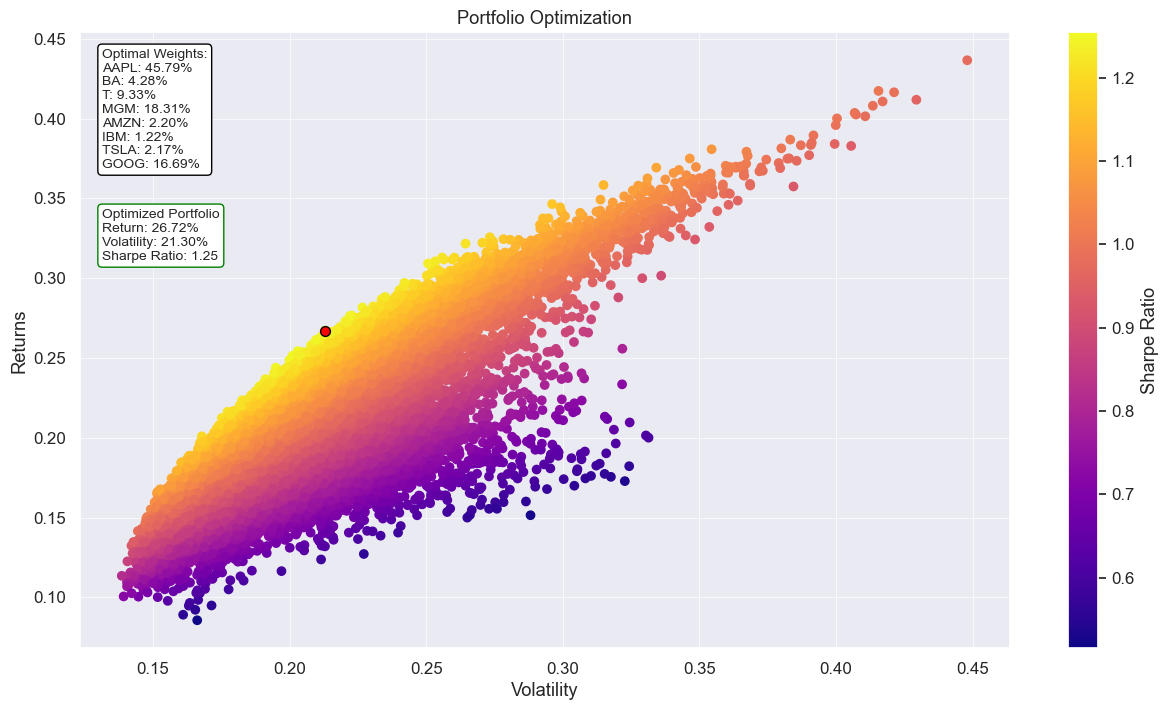

In [175]:
plot_simulation(portfolio_returns,
              portfolio_std_devs,
              sharpe_ratio,
              max_sharpe_ratio,
              max_sharpe_return,
              max_sharpe_std_dev,
              max_sharpe_weights)

# Black-Litterman Model

In [176]:
market_caps = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    market_caps[ticker] = stock.info.get('marketCap')  # Fetch market cap from the 'info' attribute

market_caps = pd.Series(market_caps, name="Market Cap")

# Display market capitalization
print(market_caps)


AAPL    3458416246784
BA       128005431296
T        159937216512
MGM        9780758528
AMZN    2375759167488
IBM      207850946560
TSLA    1369090555904
GOOG    2407818330112
Name: Market Cap, dtype: int64


In [177]:
# Obtaining closing prices for the SP500
market_prices = yf.download("^GSPC",start = '2010-07-01', end = '2015-01-01')['Close']
market_prices # Visualizing closing prices for the SP500

[*********************100%***********************]  1 of 1 completed


Ticker,^GSPC
Date,
2010-07-01 00:00:00+00:00,1027.369995
2010-07-02 00:00:00+00:00,1022.580017
2010-07-06 00:00:00+00:00,1028.060059
2010-07-07 00:00:00+00:00,1060.270020
2010-07-08 00:00:00+00:00,1070.250000
...,...
2014-12-24 00:00:00+00:00,2081.879883
2014-12-26 00:00:00+00:00,2088.770020
2014-12-29 00:00:00+00:00,2090.570068


In [178]:
cov_matrix = risk_models.sample_cov(df_data_index)
cov_matrix

Ticker,AAPL,AMZN,BA,GOOG,IBM,MGM,T,TSLA
Ticker,,,,,,,,
AAPL,0.067869,0.024666,0.019839,0.024846,0.015943,0.038407,0.010344,0.030356
AMZN,0.024666,0.104490,0.027341,0.037820,0.021380,0.050779,0.013846,0.049951
BA,0.019839,0.027341,0.054517,0.024278,0.020412,0.044015,0.014627,0.031327
GOOG,0.024846,0.037820,0.024278,0.060448,0.017805,0.041778,0.012496,0.034162
IBM,0.015943,0.021380,0.020412,0.017805,0.034111,0.031330,0.012346,0.022168
MGM,0.038407,0.050779,0.044015,0.041778,0.031330,0.171056,0.020281,0.070050
T,0.010344,0.013846,0.014627,0.012496,0.012346,0.020281,0.024030,0.013448
TSLA,0.030356,0.049951,0.031327,0.034162,0.022168,0.070050,0.013448,0.334255


In [179]:
annual_expected_returns =  mean_historical_return(df_data_index) #expected returns
annual_expected_returns

Ticker
AAPL    0.287019
AMZN    0.257046
BA      0.177877
GOOG    0.214735
IBM     0.061713
MGM     0.192180
T       0.074271
TSLA    0.673580
dtype: float64

In [180]:
Q = annual_expected_returns.to_numpy()
Q

array([0.28701869, 0.25704555, 0.17787689, 0.21473452, 0.06171276,
       0.1921804 , 0.07427131, 0.67358027])

In [181]:
n = len(Q)
P = np.eye(n)
P

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [182]:
confidences = np.random.uniform(0, 1, len(Q))
confidences

array([0.93010303, 0.60594536, 0.3334155 , 0.88252308, 0.6188029 ,
       0.38909825, 0.71306611, 0.85851001])

In [183]:

"""
cov_matrix is a NxN sample covariance matrix
mcaps is a dict of market caps
market_prices is a series of S&P500 prices
"""
delta = black_litterman.market_implied_risk_aversion(df_data_index)
prior = black_litterman.market_implied_prior_returns(market_caps, delta, cov_matrix)
prior

Ticker
AAPL    0.167948
AMZN    0.133934
BA      0.086220
GOOG    0.138543
IBM     0.042663
MGM     0.070446
T       0.043252
TSLA    0.155978
dtype: float64

In [184]:
bl = BlackLittermanModel(cov_matrix, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Method to estimate uncertainty level of the views based on historical data
                         view_confidences = confidences) # Confidences

In [185]:
rets = bl.bl_returns() # Calculating Expected returns
ef = EfficientFrontier(rets, cov_matrix) # Optimizing asset allocation

In [186]:
ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
black_litterman_weights = ef.clean_weights() # Cleaning weights
black_litterman_weights = np.array(list(black_litterman_weights.values()))

black_litterman_weights # Printing weights

array([0.46645, 0.08139, 0.03556, 0.19824, 0.     , 0.     , 0.00078,
       0.21758])

# Hierarchical Risk Parity

In [187]:
daily_returns = df_data_index[['AAPL', 'BA', 'T', 'MGM', 'AMZN', 'IBM', 'TSLA', 'GOOG']].pct_change().dropna(how="all")

annualized_mean_returns = (1 + daily_returns).prod() ** (
    252 / daily_returns.count()
) - 1

annualized_mean_returns

Ticker
AAPL    0.287019
BA      0.177877
T       0.074271
MGM     0.192180
AMZN    0.257046
IBM     0.061713
TSLA    0.673580
GOOG    0.214735
dtype: float64

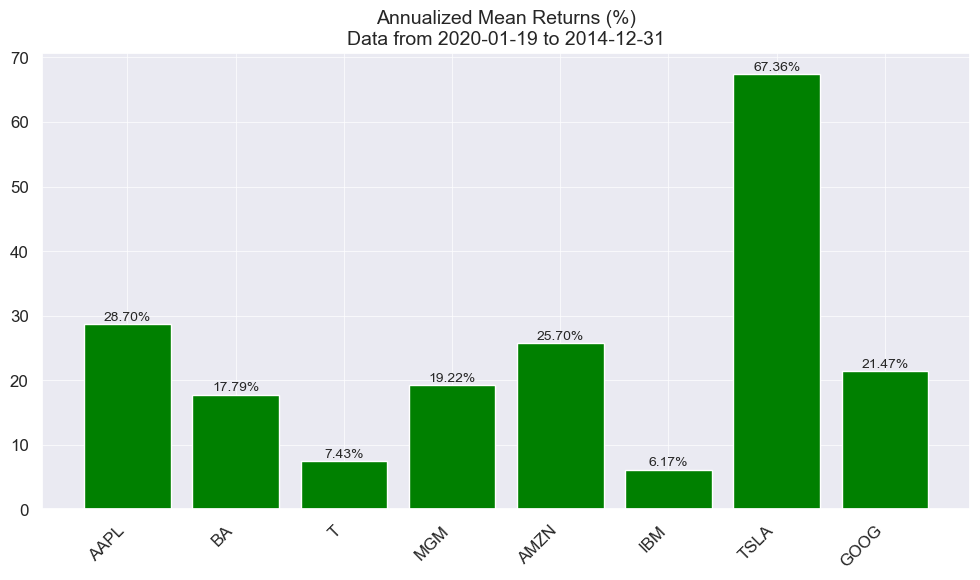

In [188]:
conditional_colors = ["green" if value > 0 else "red" for value in annualized_mean_returns]
start_date = (datetime.now() - timedelta(days=365.25 * 5)).strftime("%Y-%m-%d")

fig, ax = plt.subplots();

bars = ax.bar(
    annualized_mean_returns.index, 
    annualized_mean_returns * 100,  # Convert to percentage
    color=conditional_colors
);

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        height + np.sign(height) * 0.1,  # Add spacing to the value
        f'{height:.2f}%', 
        ha='center', va='bottom' if height > 0 else 'top',  # Adjust placement for negative values
        fontsize=10
    );

title_text = f"Annualized Mean Returns (%)\nData from {start_date} to {df_data_index.index[-1].strftime('%Y-%m-%d')}"
ax.set_title(title_text, fontsize=14);
plt.xticks(rotation=45, ha='right');
plt.tight_layout();
plt.show()

In [189]:
df_data_index

Ticker,AAPL,AMZN,BA,GOOG,IBM,MGM,T,TSLA
Date,,,,,,,,
2010-07-01,8.874286,5.5480,62.259998,10.946221,117.179733,9.700000,18.383686,1.464000
2010-07-02,8.819286,5.4570,61.939999,10.872995,116.500954,9.480000,18.345921,1.280000
2010-07-06,8.879643,5.5030,61.360001,10.861040,118.030594,9.270000,18.436556,1.074000
2010-07-07,9.238214,5.6715,63.299999,11.212971,121.414917,9.900000,18.376133,1.053333
2010-07-08,9.217500,5.8110,64.730003,11.371377,122.342255,9.820000,18.557402,1.164000
...,...,...,...,...,...,...,...,...
2014-12-24,28.002501,15.1515,131.240005,26.366112,154.703629,20.770000,25.649548,14.817333
2014-12-26,28.497499,15.4545,131.630005,26.628391,155.200760,21.110001,25.808157,15.188000
2014-12-29,28.477501,15.6020,132.289993,26.443897,153.451248,21.480000,25.762840,15.047333


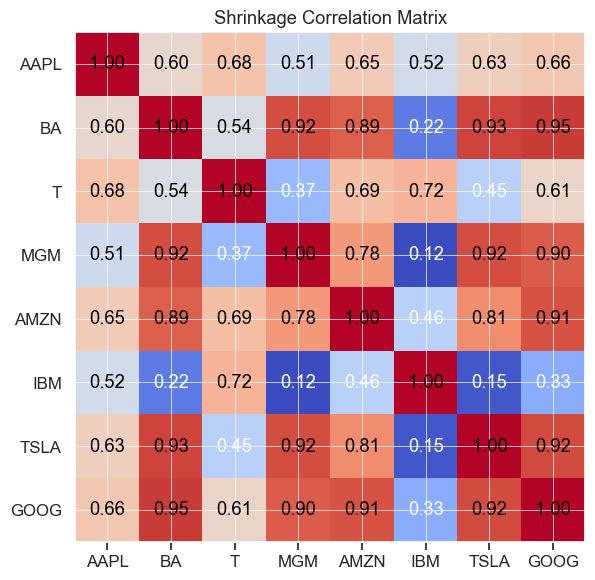

In [190]:
def to_dataframe(matrix: Union[np.ndarray, pd.DataFrame], columns: pd.Index) -> pd.DataFrame:
    return pd.DataFrame(matrix, index=columns, columns=columns)
  
# Shrinkage covariance matrix
shrinkage_covariance_matrix, _ = ledoit_wolf(
    X=df_data_index[['AAPL', 'BA', 'T', 'MGM', 'AMZN', 'IBM', 'TSLA', 'GOOG']],
    assume_centered=False,
)

# Shrinkage correlation matrix
dinv = np.diag(1 / np.sqrt(np.diag(shrinkage_covariance_matrix)))
shrinkage_correlation_matrix = np.dot(dinv, np.dot(shrinkage_covariance_matrix, dinv))

columns = df_data_index[['AAPL', 'BA', 'T', 'MGM', 'AMZN', 'IBM', 'TSLA', 'GOOG']].columns
shrinkage_covariance_matrix = to_dataframe(shrinkage_covariance_matrix, columns)
shrinkage_correlation_matrix = to_dataframe(shrinkage_correlation_matrix, columns)

fig, ax = plt.subplots();
cax = ax.matshow(shrinkage_correlation_matrix, cmap="coolwarm");
ax.xaxis.set_ticks_position('bottom');
ax.set_xticks(np.arange(len(shrinkage_correlation_matrix.columns)));
ax.set_yticks(np.arange(len(shrinkage_correlation_matrix.columns)));
ax.set_xticklabels(shrinkage_correlation_matrix.columns);
ax.set_yticklabels(shrinkage_correlation_matrix.columns);

for i in range(shrinkage_correlation_matrix.shape[0]):
    for j in range(shrinkage_correlation_matrix.shape[1]):
        # Ensure text can be easily seen
        value = shrinkage_correlation_matrix.iloc[i, j]
        color = "white" if value < 0.5 else "black"
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", color=color);

plt.title("Shrinkage Correlation Matrix");
plt.tight_layout();
plt.show()

In [191]:
dist_matrix = np.sqrt((1.0 - shrinkage_correlation_matrix.round(8)) / 2.0)
dist_matrix

Ticker,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG
Ticker,,,,,,,,
AAPL,0.000000,0.448816,0.401217,0.492858,0.421291,0.487952,0.429333,0.413146
BA,0.448816,0.000000,0.478567,0.200756,0.237383,0.623880,0.184781,0.160851
T,0.401217,0.478567,0.000000,0.559675,0.395297,0.376667,0.522079,0.440250
MGM,0.492858,0.200756,0.559675,0.000000,0.328765,0.661529,0.202186,0.228118
AMZN,0.421291,0.237383,0.395297,0.328765,0.000000,0.520420,0.310259,0.210750
IBM,0.487952,0.623880,0.376667,0.661529,0.520420,0.000000,0.651632,0.577090
TSLA,0.429333,0.184781,0.522079,0.202186,0.310259,0.651632,0.000000,0.196506
GOOG,0.413146,0.160851,0.440250,0.228118,0.210750,0.577090,0.196506,0.000000


In [192]:
condensed_dist_matrix = squareform(X=dist_matrix, checks=False)
condensed_dist_matrix

array([0.44881634, 0.40121676, 0.49285763, 0.42129147, 0.48795221,
       0.42933337, 0.41314636, 0.47856701, 0.20075593, 0.23738314,
       0.62388033, 0.18478107, 0.16085116, 0.55967509, 0.39529681,
       0.37666694, 0.52207895, 0.44024996, 0.32876542, 0.66152874,
       0.20218646, 0.22811784, 0.52041995, 0.31025867, 0.21075015,
       0.65163236, 0.57709017, 0.19650607])

In [193]:
linkage_matrix = linkage(y=condensed_dist_matrix, method="ward")
linkage_matrix

array([[ 1.        ,  7.        ,  0.16085116,  2.        ],
       [ 6.        ,  8.        ,  0.19970333,  3.        ],
       [ 3.        ,  9.        ,  0.22398973,  4.        ],
       [ 4.        , 10.        ,  0.31442046,  5.        ],
       [ 2.        ,  5.        ,  0.37666694,  2.        ],
       [ 0.        , 12.        ,  0.46771305,  3.        ],
       [11.        , 13.        ,  0.83266675,  8.        ]])

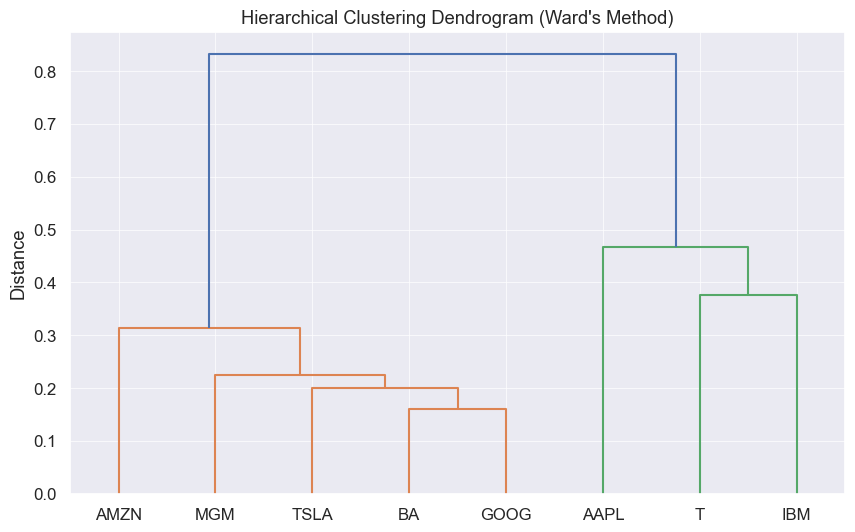

In [194]:
fig, ax = plt.subplots();
dendrogram(linkage_matrix, labels=shrinkage_correlation_matrix.columns, orientation='top');
plt.title("Hierarchical Clustering Dendrogram (Ward's Method)");
plt.ylabel("Distance");
plt.show()

In [195]:
def get_quasi_diag(linkage_matrix: np.ndarray) -> List[int]:
    """ 
    Sort clustered items by distance based on the linkage matrix.
    
    Parameters
    ----------
    linkage_matrix : np.ndarray
        The linkage matrix from hierarchical clustering.
        
    Returns
    -------
    List[int]
        The sorted indices of the clustered items.
    """
    linkage_matrix = linkage_matrix.astype(int)
    sorted_index = pd.Series([linkage_matrix[-1, 0], linkage_matrix[-1, 1]])
    print(f"Initial sorted index (last two merged clusters): {sorted_index.tolist()}")
    num_items = linkage_matrix[-1, 3]
    print(f"Number of original items: {num_items}")
    # Recursively sort clusters by distance until no clusters remain
    while sorted_index.max() >= num_items:
        print("\n--- New iteration ---\n")
        
        sorted_index.index = range(0, sorted_index.shape[0] * 2, 2)
        print(f"Expanded sorted index to make space: {sorted_index.tolist()}")
        
        cluster_indices = sorted_index[sorted_index >= num_items]
        i = cluster_indices.index  # Indices in sorted_index where clusters need to be expanded
        j = cluster_indices.values - num_items  # Row numbers in linkage_matrix to retrieve cluster members
        print(f"Identified clusters to expand:")
        print(f"    Indices in sorted_index (i): {i.tolist()}")
        print(f"    Corresponding linkage matrix rows (j): {j.tolist()}")
        # Replace clusters with their first constituent
        for idx, row_num in zip(i, j):
            row_dict = {
                'merged_1': linkage_matrix[row_num, 0],
                'merged_2': linkage_matrix[row_num, 1],
                'dist': linkage_matrix[row_num, 2],
                'number_of_original': linkage_matrix[row_num, 3]
            }
            original_cluster = sorted_index[idx]
            first_constituent = linkage_matrix[row_num, 0]
            print(f"      Row {row_num} of the linkage matrix: {row_dict}")
            print(f"      Cluster {original_cluster} was formed by merging {linkage_matrix[row_num, 0]} and {linkage_matrix[row_num, 1]}")
            print(f"      Replacing cluster {original_cluster} with its first constituent: {first_constituent}")
            sorted_index[idx] = first_constituent
        print(f"After replacing clusters with their first constituents: {sorted_index.tolist()}")
        
        # Append the second constituent of the clusters
        second_constituents = pd.Series(linkage_matrix[j, 1], index=i + 1)
        sorted_index = pd.concat([sorted_index, second_constituents])
        for idx, second_constituent in second_constituents.items():
            print(f"      Appending second constituent {second_constituent}")
        print(f"After appending the second constituents: {sorted_index.tolist()}")
        
        # Re-sort the index and reset indexing to keep proper order
        sorted_index = sorted_index.sort_index()
        sorted_index.index = range(sorted_index.shape[0])
        print(f"Final sorted index after re-sorting: {sorted_index.tolist()}")

    return sorted_index.tolist()

In [196]:
sorted_index = get_quasi_diag(linkage_matrix)

Initial sorted index (last two merged clusters): [11, 13]
Number of original items: 8

--- New iteration ---

Expanded sorted index to make space: [11, 13]
Identified clusters to expand:
    Indices in sorted_index (i): [0, 2]
    Corresponding linkage matrix rows (j): [3, 5]
      Row 3 of the linkage matrix: {'merged_1': 4, 'merged_2': 10, 'dist': 0, 'number_of_original': 5}
      Cluster 11 was formed by merging 4 and 10
      Replacing cluster 11 with its first constituent: 4
      Row 5 of the linkage matrix: {'merged_1': 0, 'merged_2': 12, 'dist': 0, 'number_of_original': 3}
      Cluster 13 was formed by merging 0 and 12
      Replacing cluster 13 with its first constituent: 0
After replacing clusters with their first constituents: [4, 0]
      Appending second constituent 10
      Appending second constituent 12
After appending the second constituents: [4, 0, 10, 12]
Final sorted index after re-sorting: [4, 10, 0, 12]

--- New iteration ---

Expanded sorted index to make space:

In [197]:
sorted_index

[4, 3, 6, 1, 7, 0, 2, 5]

In [198]:
sorted_correlation_matrix = shrinkage_correlation_matrix.iloc[sorted_index, sorted_index]

In [199]:
ordered_tickers = shrinkage_correlation_matrix.index[sorted_index]
ordered_tickers

Index(['AMZN', 'MGM', 'TSLA', 'BA', 'GOOG', 'AAPL', 'T', 'IBM'], dtype='object', name='Ticker')

In [200]:
def get_ivp(cov: pd.DataFrame) -> np.ndarray:
    """
    Compute the inverse variance portfolio (IVP) for a given covariance matrix.

    Parameters
    ----------
    cov : pd.DataFrame
        Covariance matrix of the cluster.

    Returns
    -------
    np.ndarray
        Inverse variance portfolio weights for the cluster.
    """
    ivp = 1.0 / np.diag(cov)
    ivp /= ivp.sum()  # Normalize weights
    print(f"\n    IVP weights for cluster: {ivp}")
    return ivp

In [201]:
def get_cluster_var(cov: pd.DataFrame, cluster_items: List[str]) -> float:
    """
    Compute the variance for a given cluster.

    Parameters
    ----------
    cov : pd.DataFrame
        Covariance matrix for the assets.
    cluster_items : List[str]
        List of tickers in the cluster.

    Returns
    -------
    float
        The variance of the cluster.
    """
    # Subset of the covariance matrix containing only the cluster assets
    cov_slice = cov.loc[cluster_items, cluster_items]
    # Define the left space (4 spaces in this case)
    hspace = "    "
    formatted_cov_slice = str(cov_slice).replace("\n", "\n" + hspace)
    print(f"\n    Covariance matrix slice for cluster {cluster_items}:\n{hspace}{formatted_cov_slice}")
    # Calculate inverse variance portfolio (IVP) weights for the cluster and reshape to column vector (n x 1)
    weights = get_ivp(cov_slice).reshape(-1, 1)
    # Compute cluster variance as w.T * cov_slice * w, which is [1 x n] * [n x n] * [n x 1] = [1 x 1]
    cluster_var = np.dot(np.dot(weights.T, cov_slice), weights)[0, 0]
    print(f"\n    Cluster variance for {cluster_items}: {cluster_var}\n")
    return cluster_var

In [202]:
def recursive_bisection(cov: pd.DataFrame, ordered_tickers: Union[pd.Index, List[str]]) -> pd.Series:
    """
    Compute the Hierarchical Risk Parity (HRP) portfolio allocation using recursive bisection.

    Parameters
    ----------
    cov : pd.DataFrame
        Covariance matrix for the assets.
    ordered_tickers : Union[pd.Index, List[str]]
        List of tickers ordered by hierarchical clustering.

    Returns
    -------
    pd.Series
        Portfolio weights for each asset.
    """
    # Initialize equal weights for all assets
    weights = pd.Series(1.0, index=ordered_tickers)
    hspace = "    "  # Define the left space (4 spaces in this case)
    formatted_weights = str(weights).replace("\n", "\n" + hspace)
    print(f"Initial weights:\n{hspace}{formatted_weights}\n")
    # Initialize the cluster as the full set of ordered tickers
    cluster_items = [ordered_tickers]
    
    step = 0
    while len(cluster_items) > 0:
        step += 1
        print(f"\n{'='*20} Step {step}: Recursive Bisection {'='*20}\n")
        print(f"Cluster items at Step {step}: {[list(cluster) for cluster in cluster_items]}")
        # Split each cluster into two halves only if the cluster contains more than one asset
        cluster_items = [
            i[j:k]
            for i in cluster_items
            for j, k in ((0, len(i) // 2), (len(i) // 2, len(i)))
            if len(i) > 1
        ]
        # For each pair of clusters, calculate variance and adjust weights
        for i in range(0, len(cluster_items), 2):
            first_cluster = cluster_items[i]
            second_cluster = cluster_items[i + 1]
            print(f"\n    ---- Processing clusters ----")
            print(f"    First cluster: {first_cluster}")
            print(f"    Second cluster: {second_cluster}")
            # Compute variance for each cluster
            first_var = get_cluster_var(cov, list(first_cluster))
            second_var = get_cluster_var(cov, list(second_cluster))
            # Compute the weighting factor alpha
            alpha = 1 - first_var / (first_var + second_var)
            print(f"    Weighting factor alpha for {list(first_cluster)}: {alpha}")
            print(f"    Weighting factor 1 - alpha for {list(second_cluster)}: {1 - alpha}")
            # Adjust weights for each cluster
            weights[first_cluster] *= alpha
            weights[second_cluster] *= 1 - alpha
            formatted_weights = str(weights).replace("\n", "\n" + hspace)
            print(f"    Updated weights after adjustment:\n{hspace}{formatted_weights}\n")
    return weights

In [203]:
hrp_weights = recursive_bisection(cov=shrinkage_covariance_matrix, ordered_tickers=ordered_tickers)

Initial weights:
    Ticker
    AMZN    1.0
    MGM     1.0
    TSLA    1.0
    BA      1.0
    GOOG    1.0
    AAPL    1.0
    T       1.0
    IBM     1.0
    dtype: float64


==================== Step 1: Recursive Bisection ====================

Cluster items at Step 1: [['AMZN', 'MGM', 'TSLA', 'BA', 'GOOG', 'AAPL', 'T', 'IBM']]

    ---- Processing clusters ----
    First cluster: Index(['AMZN', 'MGM', 'TSLA', 'BA'], dtype='object', name='Ticker')
    Second cluster: Index(['GOOG', 'AAPL', 'T', 'IBM'], dtype='object', name='Ticker')

    Covariance matrix slice for cluster ['AMZN', 'MGM', 'TSLA', 'BA']:
    Ticker       AMZN         MGM        TSLA          BA
    Ticker                                               
    AMZN    12.341601   15.027681   15.840908   81.426426
    MGM     15.027681   29.783276   27.983760  131.068349
    TSLA    15.840908   27.983760   31.183585  135.910982
    BA      81.426426  131.068349  135.910982  682.369743

    IVP weights for cluster: [0.54697

In [204]:
hrp_weights.sort_index()

Ticker
AAPL    0.092400
AMZN    0.175336
BA      0.003935
GOOG    0.067376
IBM     0.007794
MGM     0.072656
T       0.494400
TSLA    0.086103
dtype: float64

In [205]:
# Define the desired order
order = ['AAPL', 'BA', 'T', 'MGM', 'AMZN', 'IBM', 'TSLA', 'GOOG']
# Create the array by reordering the values in hrp_weights
hrp_ordered_values = np.array([float(hrp_weights[ticker]) for ticker in order])
hrp_ordered_values

array([0.09240037, 0.00393483, 0.49440015, 0.07265565, 0.1753357 ,
       0.00779386, 0.08610339, 0.06737605])

# Comparing results

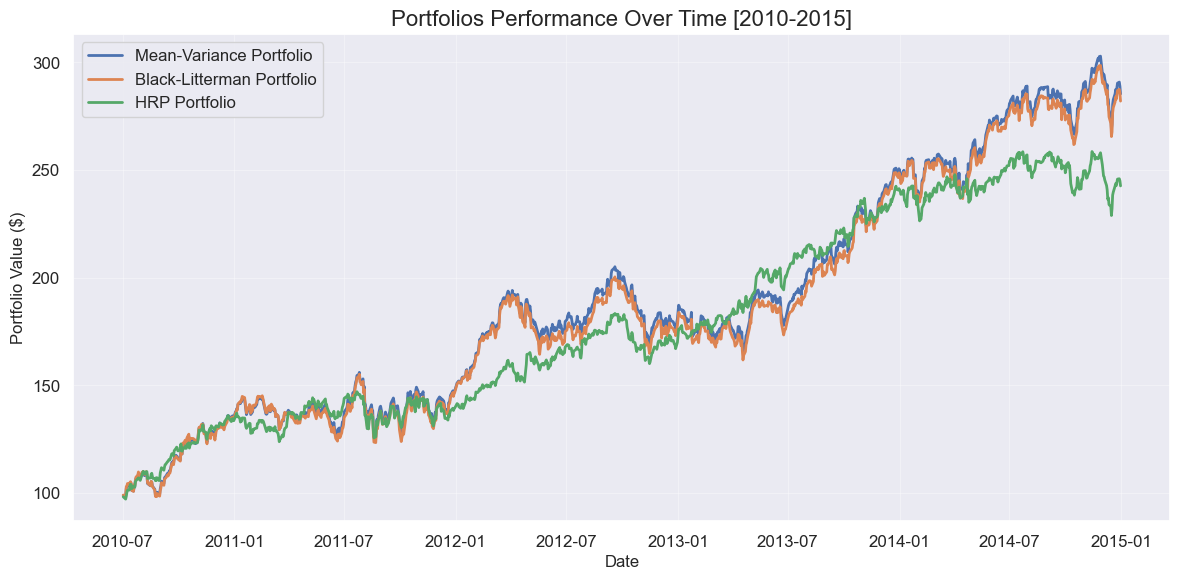

In [206]:
# Ensure weights are numpy arrays
weights1 = max_sharpe_weights
weights2 = black_litterman_weights
weights3 = hrp_ordered_values

weights1 = np.array(weights1)
weights2 = np.array(weights2)
weights3 = np.array(weights3)

# Extract only the columns corresponding to the 8 assets in df_data_index
selected_assets = ['AAPL', 'BA', 'T', 'MGM', 'AMZN', 'IBM', 'TSLA', 'GOOG']
df_assets = df_data_index[selected_assets]

# Calculate daily returns for each asset
daily_returns = df_assets.pct_change().dropna()

# Calculate daily portfolio returns for each portfolio
portfolio1_returns = (daily_returns * weights1).sum(axis=1)
portfolio2_returns = (daily_returns * weights2).sum(axis=1)
portfolio3_returns = (daily_returns * weights3).sum(axis=1)

# Compute cumulative portfolio values (starting with $100 investment)
initial_investment = 100
portfolio1_values = initial_investment * (1 + portfolio1_returns).cumprod()
portfolio2_values = initial_investment * (1 + portfolio2_returns).cumprod()
portfolio3_values = initial_investment * (1 + portfolio3_returns).cumprod()

# Plot the portfolios over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio1_values, label='Mean-Variance Portfolio', linewidth=2)
plt.plot(portfolio2_values, label='Black-Litterman Portfolio', linewidth=2)
plt.plot(portfolio3_values, label='HRP Portfolio', linewidth=2)

# Add labels, legend, and title
plt.title('Portfolios Performance Over Time [2010-2015]', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

# Getting the data for period 2015-2020

In [207]:
start_date = '2015-01-01'
end_date = '2020-01-31'
tickers = ['AAPL', 'BA', 'T', 'MGM', 'AMZN', 'IBM', 'TSLA', 'GOOG']

# Download daily data
data = yf.download(tickers=tickers, start=start_date, end=end_date, interval='1d')
# Select only columns that contain "Close" in their names

close_columns = [col for col in data.columns if 'Close' in col]
data = data[close_columns]

# Convert the index to datetime and format it to show only the year, month, and day
data.index = pd.to_datetime(data.index).date

# Ensure the index is named appropriately
data.index.name = 'Date'

data = data.reset_index()

#df_data = pd.read_csv('Stocks&s&p500_data.csv')
# Now, sort the DataFrame by 'Date'
data_sorted = data.sort_values(by='Date')
# Flatten the columns
data.columns = data.columns.get_level_values(1)

# Optionally, reset the index after sorting (if you want a clean index)
#df_data = df_data_sorted.reset_index(drop=True)
# Rename the first column as 'Date'
data.rename(columns={data.columns[0]: 'Date'}, inplace=True)

# Ensure 'Date' is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)
# Convert 'Date' column to a proper datetime format (if not already)
#data['Date'] = pd.to_datetime(data['Date'])


# Set the 'Date' column as the index
#data.set_index('Date', inplace=True)

data

[*********************100%***********************]  8 of 8 completed


Ticker,AAPL,AMZN,BA,GOOG,IBM,MGM,T,TSLA
Date,,,,,,,,
2015-01-02,27.332500,15.426000,129.949997,26.168653,154.933075,21.020000,25.581572,14.620667
2015-01-05,26.562500,15.109500,129.050003,25.623152,152.495224,20.440001,25.339878,14.006000
2015-01-06,26.565001,14.764500,127.529999,25.029282,149.206497,19.660000,25.377644,14.085333
2015-01-07,26.937500,14.921000,129.509995,24.986401,148.231354,20.430000,25.052870,14.063333
2015-01-08,27.972500,15.023000,131.800003,25.065184,151.453156,20.719999,25.302114,14.041333
...,...,...,...,...,...,...,...,...
2020-01-24,79.577499,93.082001,323.049988,73.335503,134.378586,31.570000,29.078550,37.654667
2020-01-27,77.237503,91.417000,316.600006,71.695000,132.523895,30.350000,28.889729,37.201332
2020-01-28,79.422501,92.662498,316.559998,72.627998,133.412994,30.969999,29.138973,37.793331


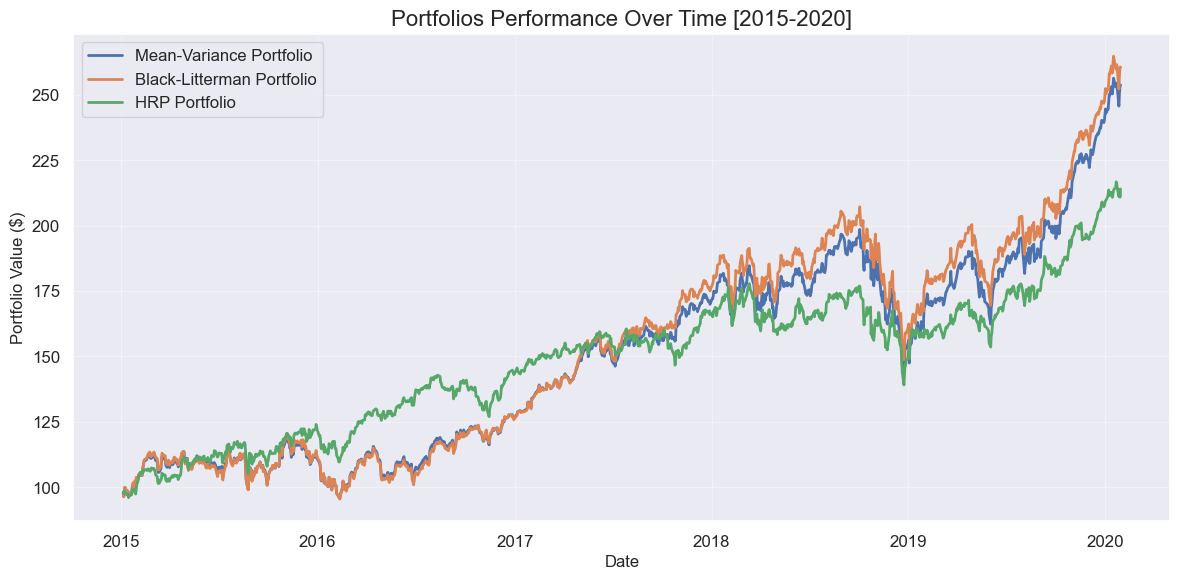

In [208]:
# Ensure weights are numpy arrays
weights1 = max_sharpe_weights
weights2 = black_litterman_weights
weights3 = hrp_ordered_values

weights1 = np.array(weights1)
weights2 = np.array(weights2)
weights3 = np.array(weights3)

# Extract only the columns corresponding to the 8 assets in df_data_index
selected_assets = ['AAPL', 'BA', 'T', 'MGM', 'AMZN', 'IBM', 'TSLA', 'GOOG']
df_assets_after = data[selected_assets]

# Calculate daily returns for each asset
daily_returns_after = df_assets_after.pct_change().dropna()

# Calculate daily portfolio returns for each portfolio
portfolio1_returns_after = (daily_returns_after * weights1).sum(axis=1)
portfolio2_returns_after = (daily_returns_after * weights2).sum(axis=1)
portfolio3_returns_after = (daily_returns_after * weights3).sum(axis=1)

# Compute cumulative portfolio values (starting with $100 investment)
initial_investment = 100
portfolio1_values_after = initial_investment * (1 + portfolio1_returns_after).cumprod()
portfolio2_values_after = initial_investment * (1 + portfolio2_returns_after).cumprod()
portfolio3_values_after = initial_investment * (1 + portfolio3_returns_after).cumprod()

# Plot the portfolios over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio1_values_after, label='Mean-Variance Portfolio', linewidth=2)
plt.plot(portfolio2_values_after, label='Black-Litterman Portfolio', linewidth=2)
plt.plot(portfolio3_values_after, label='HRP Portfolio', linewidth=2)

# Add labels, legend, and title
plt.title('Portfolios Performance Over Time [2015-2020]', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

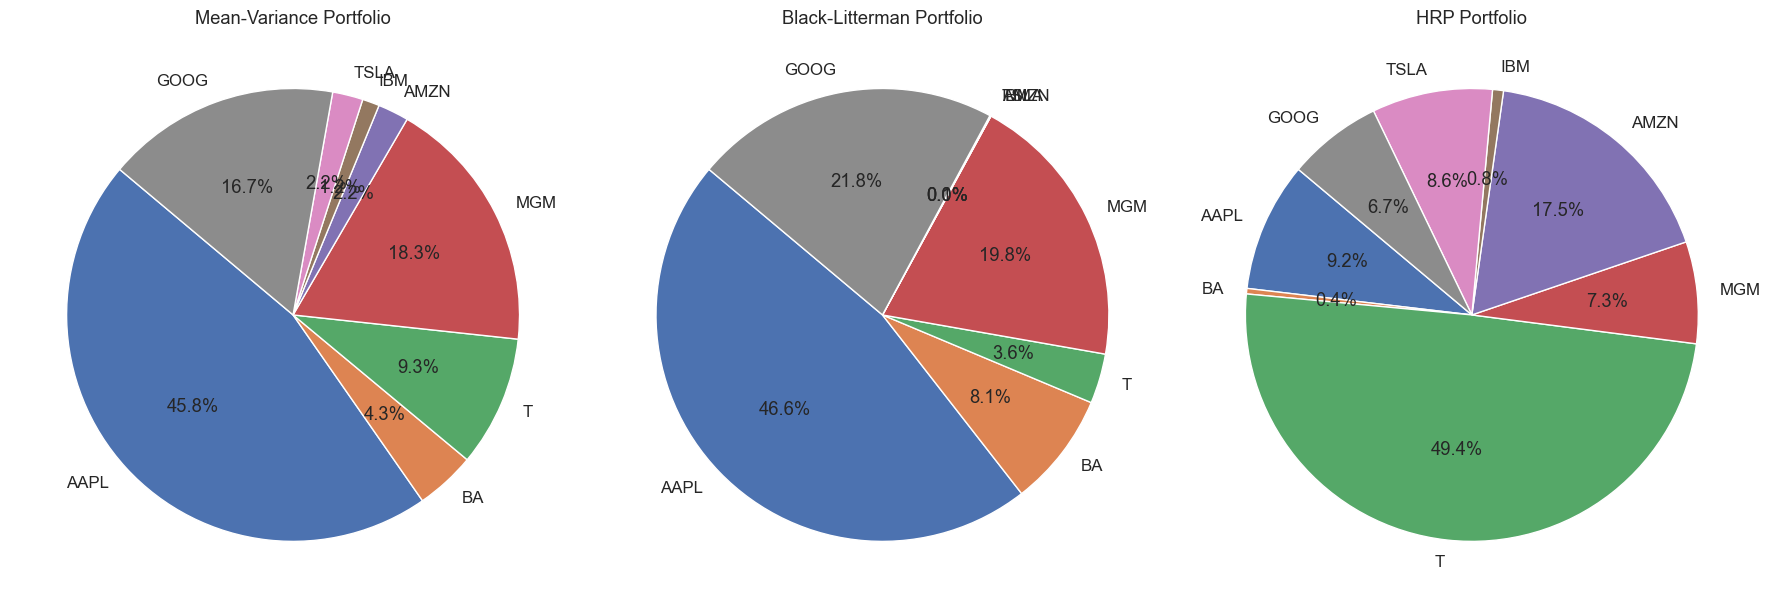

In [209]:
# Define portfolio weights and stock names
# Assuming weights1, weights2, and weights3 contain the weights of the stocks
stock_names = selected_assets  # Column names from the DataFrame

# Normalize weights to ensure they sum to 1 (if not already normalized)
weights1 = np.array(weights1) / np.sum(weights1)
weights2 = np.array(weights2) / np.sum(weights2)
weights3 = np.array(weights3) / np.sum(weights3)  # Added for Portfolio 3

# Create subplots for side-by-side pie charts
fig, axes = plt.subplots(1, 3, figsize=(18, 7))  # Adjusted for 3 subplots

# Plot Portfolio 1
axes[0].pie(weights1, labels=stock_names, autopct='%1.1f%%', startangle=140)
axes[0].set_title("Mean-Variance Portfolio")

# Plot Portfolio 2
axes[1].pie(weights2, labels=stock_names, autopct='%1.1f%%', startangle=140)
axes[1].set_title("Black-Litterman Portfolio")

# Plot Portfolio 3
axes[2].pie(weights3, labels=stock_names, autopct='%1.1f%%', startangle=140)  # Added for Portfolio 3
axes[2].set_title("HRP Portfolio")

# Adjust layout and display the charts
plt.tight_layout()
plt.show()


In [210]:
returns = compute_returns(df_data)  
avg_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

portfolio_return1 = np.sum(avg_returns * weights1)
portfolio_std_dev1 = np.sqrt(np.dot(weights1.T, np.dot(cov_matrix, weights1)))
sharpe1 = (portfolio_return1)/portfolio_std_dev1

portfolio_return2 = np.sum(avg_returns * weights2)
portfolio_std_dev2 = np.sqrt(np.dot(weights2.T, np.dot(cov_matrix, weights2)))
sharpe2 = (portfolio_return2)/portfolio_std_dev2

portfolio_return3 = np.sum(avg_returns * weights3)
portfolio_std_dev3 = np.sqrt(np.dot(weights3.T, np.dot(cov_matrix, weights3)))
sharpe3 = (portfolio_return3)/portfolio_std_dev3

In [211]:
data_index = data.reset_index()
data_index.rename(columns={"index": "Date"}, inplace=True)  # Rename the index column to "Date" if needed
data_index

Ticker,Date,AAPL,AMZN,BA,GOOG,IBM,MGM,T,TSLA
0,2015-01-02,27.332500,15.426000,129.949997,26.168653,154.933075,21.020000,25.581572,14.620667
1,2015-01-05,26.562500,15.109500,129.050003,25.623152,152.495224,20.440001,25.339878,14.006000
2,2015-01-06,26.565001,14.764500,127.529999,25.029282,149.206497,19.660000,25.377644,14.085333
3,2015-01-07,26.937500,14.921000,129.509995,24.986401,148.231354,20.430000,25.052870,14.063333
4,2015-01-08,27.972500,15.023000,131.800003,25.065184,151.453156,20.719999,25.302114,14.041333
...,...,...,...,...,...,...,...,...,...
1273,2020-01-24,79.577499,93.082001,323.049988,73.335503,134.378586,31.570000,29.078550,37.654667
1274,2020-01-27,77.237503,91.417000,316.600006,71.695000,132.523895,30.350000,28.889729,37.201332
1275,2020-01-28,79.422501,92.662498,316.559998,72.627998,133.412994,30.969999,29.138973,37.793331
1276,2020-01-29,81.084999,92.900002,322.019989,72.931503,131.634796,31.270000,27.983383,38.732666


In [212]:
returns = compute_returns(data_index)  
avg_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

portfolio_return1_after = np.sum(avg_returns * weights1)
portfolio_std_dev1_after = np.sqrt(np.dot(weights1.T, np.dot(cov_matrix, weights1)))
sharpe1_after = (portfolio_return1_after)/portfolio_std_dev1_after

portfolio_return2_after = np.sum(avg_returns * weights2)
portfolio_std_dev2_after = np.sqrt(np.dot(weights2.T, np.dot(cov_matrix, weights2)))
sharpe2_after = (portfolio_return2_after)/portfolio_std_dev2_after

portfolio_return3_after = np.sum(avg_returns * weights3)
portfolio_std_dev3_after = np.sqrt(np.dot(weights3.T, np.dot(cov_matrix, weights3)))
sharpe3_after = (portfolio_return3_after)/portfolio_std_dev3_after

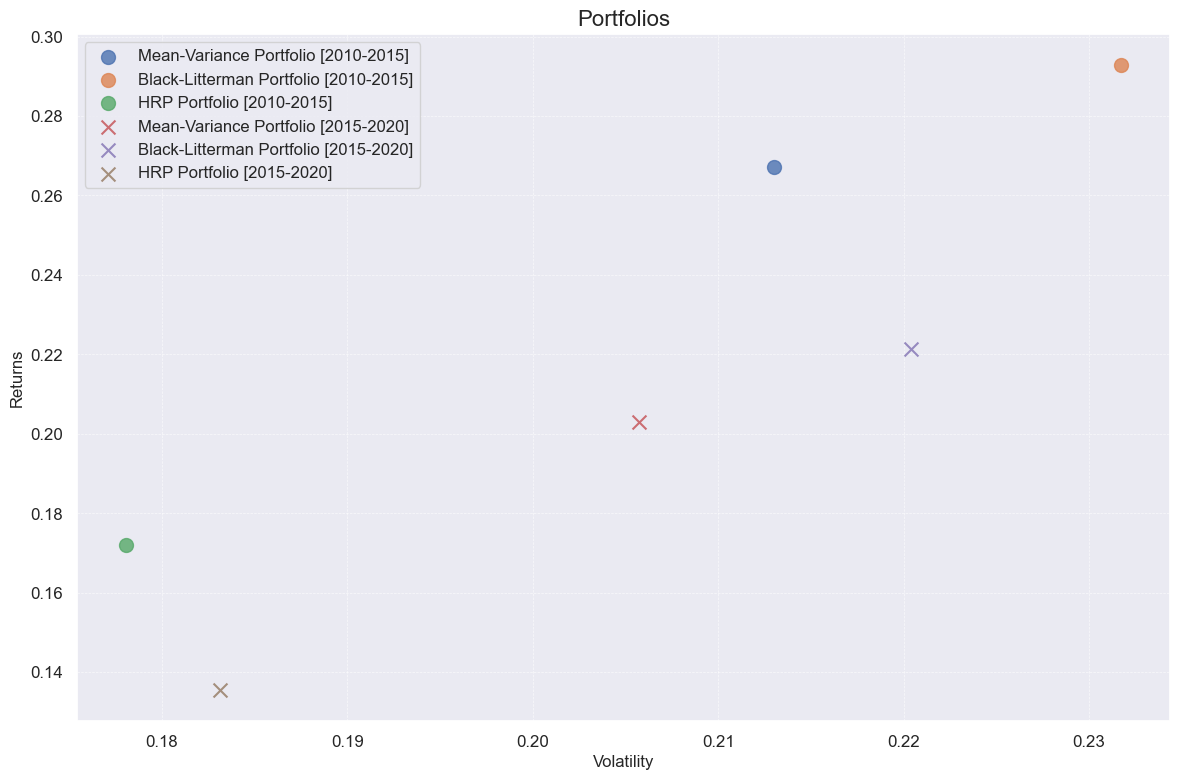

In [213]:
# Data for plotting (before optimization)
volatility_before = [portfolio_std_dev1, portfolio_std_dev2, portfolio_std_dev3]
returns_before = [portfolio_return1, portfolio_return2, portfolio_return3]
labels_before = ["Mean-Variance Portfolio [2010-2015]", "Black-Litterman Portfolio [2010-2015]", "HRP Portfolio [2010-2015]"]

# Data for plotting (after optimization)
volatility_after = [portfolio_std_dev1_after, portfolio_std_dev2_after, portfolio_std_dev3_after]
returns_after = [portfolio_return1_after, portfolio_return2_after, portfolio_return3_after]
labels_after = ["Mean-Variance Portfolio [2015-2020]", "Black-Litterman Portfolio [2015-2020]", "HRP Portfolio [2015-2020]"]

# Create a scatter plot
plt.figure(figsize=(12, 8))

# Plot the "before" portfolios
for i in range(len(volatility_before)):
    plt.scatter(volatility_before[i], returns_before[i], label=labels_before[i], marker='o', s=100, alpha=0.8)

# Plot the "after" portfolios
for i in range(len(volatility_after)):
    plt.scatter(volatility_after[i], returns_after[i], label=labels_after[i], marker='x', s=100, alpha=0.8)

# Add titles and labels
plt.title("Portfolios", fontsize=16)
plt.xlabel("Volatility", fontsize=12)
plt.ylabel("Returns", fontsize=12)

# Add grid
plt.grid(True, linestyle="--", alpha=0.7)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Quantstats

In [214]:
# Initialize the optimized_portfolio as a Series of zeros, matching the index of stock_daily_return_df
optimized_portfolio1 = pd.Series(0, index=stock_daily_return_df.index)

# Loop through the stocks and their corresponding weights to calculate the weighted sum
for stock, weight in zip(['AAPL', 'AMZN', 'BA', 'GOOG', 'IBM', 'MGM', 'T', 'TSLA'], weights1):
    optimized_portfolio1 += weight * stock_daily_return_df[stock]

# Convert optimized_portfolio to a DataFrame with 'Date' as the index and a single column
optimized_portfolio1 = pd.DataFrame({'Return': optimized_portfolio1})

# Set 'Date' as the index (if it's not already set)
optimized_portfolio1.index = stock_daily_return_df['Date']

# Remove any extra column levels and keep only one level of titles
optimized_portfolio1.index.name = 'Date'

optimized_portfolio1.index = pd.to_datetime(optimized_portfolio1.index)

optimized_portfolio1.columns = ['Returns']

optimized_portfolio1 = optimized_portfolio1.asfreq('D')

optimized_portfolio1 = optimized_portfolio1.dropna()

# Display the resulting DataFrame
optimized_portfolio1

,Returns
Date,
2010-07-01,0.000000
2010-07-02,-2.667208
2010-07-06,-2.431842
2010-07-07,2.686180
2010-07-08,2.254162
...,...
2014-12-24,-0.159748
2014-12-26,1.562922
2014-12-29,-0.233266


In [215]:
# Initialize the optimized_portfolio as a Series of zeros, matching the index of stock_daily_return_df
optimized_portfolio2 = pd.Series(0, index=stock_daily_return_df.index)

# Loop through the stocks and their corresponding weights to calculate the weighted sum
for stock, weight in zip(['AAPL', 'AMZN', 'BA', 'GOOG', 'IBM', 'MGM', 'T', 'TSLA'], weights2):
    optimized_portfolio2 += weight * stock_daily_return_df[stock]

# Convert optimized_portfolio to a DataFrame with 'Date' as the index and a single column
optimized_portfolio2 = pd.DataFrame({'Return': optimized_portfolio2})

# Set 'Date' as the index (if it's not already set)
optimized_portfolio2.index = stock_daily_return_df['Date']

# Remove any extra column levels and keep only one level of titles
optimized_portfolio2.index.name = 'Date'

optimized_portfolio2.index = pd.to_datetime(optimized_portfolio2.index)

optimized_portfolio2.columns = ['Returns']

optimized_portfolio2 = optimized_portfolio2.asfreq('D')

optimized_portfolio2 = optimized_portfolio2.dropna()

# Display the resulting DataFrame
optimized_portfolio2

,Returns
Date,
2010-07-01,0.000000
2010-07-02,-3.308250
2010-07-06,-3.168552
2010-07-07,2.468634
2010-07-08,2.742737
...,...
2014-12-24,-0.214347
2014-12-26,1.739849
2014-12-29,-0.276228


In [216]:
# Initialize the optimized_portfolio as a Series of zeros, matching the index of stock_daily_return_df
optimized_portfolio3 = pd.Series(0, index=stock_daily_return_df.index)

# Loop through the stocks and their corresponding weights to calculate the weighted sum
for stock, weight in zip(['AAPL', 'AMZN', 'BA', 'GOOG', 'IBM', 'MGM', 'T', 'TSLA'], weights3):
    optimized_portfolio3 += weight * stock_daily_return_df[stock]

# Convert optimized_portfolio to a DataFrame with 'Date' as the index and a single column
optimized_portfolio3 = pd.DataFrame({'Returns': optimized_portfolio3})

# Set 'Date' as the index (if it's not already set)
optimized_portfolio3.index = stock_daily_return_df['Date']

# Remove any extra column levels and keep only one level of titles
optimized_portfolio3.index.name = 'Date'

optimized_portfolio3.index = pd.to_datetime(optimized_portfolio3.index)

optimized_portfolio3 = optimized_portfolio3.dropna()

# Display the resulting DataFrame
optimized_portfolio3

,Returns
Date,
2010-07-01,0.000000
2010-07-02,-1.350166
2010-07-06,-1.233232
2010-07-07,2.581568
2010-07-08,2.128928
...,...
2014-12-24,0.357347
2014-12-26,0.681289
2014-12-29,-0.066686


In [217]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

risk_free_rate = 0.0  # Risk-free rate (daily)

# Define a function to calculate portfolio metrics
def calculate_metrics(daily_returns, risk_free_rate=0):
    metrics = {}
    annualization_factor = 252  # Trading days in a year

    # Annualized return
    metrics["Return (%)"] = daily_returns.mean() * annualization_factor * 100

    # Annualized volatility (standard deviation)
    metrics["Volatility (%)"] = daily_returns.std() * np.sqrt(annualization_factor) * 100

    # Sharpe Ratio
    excess_return = daily_returns.mean() - risk_free_rate
    metrics["Sharpe Ratio"] = (excess_return * annualization_factor) / (
        daily_returns.std() * np.sqrt(annualization_factor)
    )

    # Maximum Drawdown
    cumulative_returns = (1 + daily_returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdowns = (cumulative_returns / rolling_max - 1)
    metrics["Max Drawdown (%)"] = drawdowns.min() * 100

    
    # Skewness and Kurtosis
    metrics["Skewness"] = skew(daily_returns)
    metrics["Kurtosis"] = kurtosis(daily_returns)

    return metrics

In [218]:
portfolio1_metrics = calculate_metrics(portfolio1_returns)
portfolio2_metrics = calculate_metrics(portfolio2_returns)
portfolio3_metrics = calculate_metrics(portfolio3_returns)

In [219]:
comparison_df = pd.DataFrame([portfolio1_metrics, portfolio2_metrics, portfolio3_metrics],
                             index=["Portfolio 1", "Portfolio 2", "Portfolio 3"])


In [220]:
comparison_df

,Return (%),Volatility (%),Sharpe Ratio,Max Drawdown (%),Skewness,Kurtosis
Portfolio 1,25.434548,20.540205,1.238281,-19.338654,-0.218104,1.821142
Portfolio 2,25.326459,21.271156,1.190648,-20.452117,-0.205675,1.903424
Portfolio 3,21.117500,16.738759,1.261593,-14.569913,-0.252046,1.556318


In [225]:
returns = compute_returns(df_data)
avg_returns = returns.mean() * 252

annualized_mean_returns = (1 + returns).prod() ** (
    252 / returns.count()
) - 1


portfolio1_return = np.sum(avg_returns * weights1)
portfolio1_std_dev = np.sqrt(np.dot(weights1.T, np.dot(cov_matrix, weights1)))
sharpe1 = (portfolio1_return)/portfolio1_std_dev

portfolio2_return = np.sum(avg_returns * weights2)
portfolio2_std_dev = np.sqrt(np.dot(weights2.T, np.dot(cov_matrix, weights1)))
sharpe2 = (portfolio2_return)/portfolio2_std_dev

portfolio3_return = np.sum(avg_returns * weights3)
portfolio3_std_dev = np.sqrt(np.dot(weights3.T, np.dot(cov_matrix, weights3)))
sharpe3 = (portfolio3_return)/portfolio3_std_dev

# Create a dictionary for DataFrame
metrics = {
    "Return": [portfolio1_return, portfolio2_return, portfolio3_return],
    "Volatility": [portfolio1_std_dev, portfolio2_std_dev, portfolio3_std_dev],
    "Sharpe Ratio": [sharpe1, sharpe2, sharpe3]
}

# Create DataFrame with rows as portfolios
metrics_df_2012_20 = pd.DataFrame(metrics, index=["Mean-Variance Portfolio", "Black-Litterman Portfolio", "HRP Portfolio"])

metrics_df_2012_20

,Return,Volatility,Sharpe Ratio
Mean-Variance Portfolio,0.267208,0.205732,1.298815
Black-Litterman Portfolio,0.292804,0.212228,1.379667
HRP Portfolio,0.172024,0.183135,0.939325


In [224]:
returns = np.log(data/data.shift(1))

avg_returns = returns.mean() * 252

portfolio1_return = np.sum(avg_returns * weights1)
portfolio1_std_dev = np.sqrt(np.dot(weights1.T, np.dot(cov_matrix, weights1)))
sharpe1 = (portfolio1_return)/portfolio1_std_dev

portfolio2_return = np.sum(avg_returns * weights2)
portfolio2_std_dev = np.sqrt(np.dot(weights2.T, np.dot(cov_matrix, weights1)))
sharpe2 = (portfolio2_return)/portfolio2_std_dev

portfolio3_return = np.sum(avg_returns * weights3)
portfolio3_std_dev = np.sqrt(np.dot(weights3.T, np.dot(cov_matrix, weights3)))
sharpe3 = (portfolio3_return)/portfolio3_std_dev

# Create a dictionary for DataFrame
metrics = {
    "Return": [portfolio1_return, portfolio2_return, portfolio3_return],
    "Volatility": [portfolio1_std_dev, portfolio2_std_dev, portfolio3_std_dev],
    "Sharpe Ratio": [sharpe1, sharpe2, sharpe3]
}

# Create DataFrame with rows as portfolios
metrics_df_2020_23 = pd.DataFrame(metrics, index=["Mean-Variance Portfolio", "Black-Litterman Portfolio", "HRP Portfolio"])

metrics_df_2020_23

,Return,Volatility,Sharpe Ratio
Mean-Variance Portfolio,0.203065,0.205732,0.987038
Black-Litterman Portfolio,0.221380,0.212228,1.043123
HRP Portfolio,0.135488,0.183135,0.739826
